## Compare Original Location Patch vs Refined Location Patch

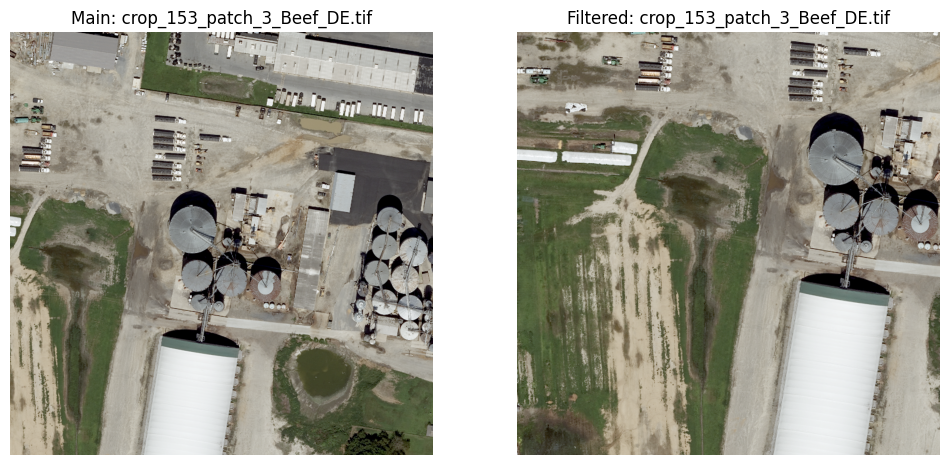

In [1]:
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt
import rasterio
import numpy as np
from ipywidgets import Button, HBox, VBox, Output
from IPython.display import display

# === CONFIG ===
main_metadata_path = '/project/biocomplexity/gza5dr/CAFO/exp_v2/main_experiments/data_preparation/datas/cafo_data/patch_metadata/single_patch_metadata_DE.csv'
filtered_metadata_path = '/project/biocomplexity/gza5dr/CAFO/exp_v2/main_experiments/data_preparation/datas/cafo_data/patch_metadata/single_patch_metadata_DE_filtered.csv'
main_patch_dir = "/project/biocomplexity/gza5dr/CAFO/exp_v2/main_experiments/data_preparation/datas/cafo_data/point_single_patches/DE"
filtered_patch_dir = "/project/biocomplexity/gza5dr/CAFO/exp_v2/main_experiments/data_preparation/datas/cafo_data/point_single_patches/DE_filtered"
verified_dir = "/project/biocomplexity/gza5dr/CAFO/exp_v2/main_experiments/data_preparation/datas/cafo_data/point_single_patches/DE_verified"
verified_metadata_path = "/project/biocomplexity/gza5dr/CAFO/exp_v2/main_experiments/data_preparation/datas/cafo_data/patch_metadata/verified_metadata.csv"

os.makedirs(verified_dir, exist_ok=True)

# === Load metadata ===
main_df = pd.read_csv(main_metadata_path)
filtered_df = pd.read_csv(filtered_metadata_path)
merged_df = pd.merge(main_df, filtered_df, on='unique_id', suffixes=('_main', '_filtered'))

# === Load existing verified metadata if exists ===
if os.path.exists(verified_metadata_path):
    verified_metadata_df = pd.read_csv(verified_metadata_path)
else:
    verified_metadata_df = pd.DataFrame()

# === Helper to read patch image ===
def read_patch_image(path):
    with rasterio.open(path) as src:
        img = src.read([1, 2, 3])
        img = np.transpose(img, (1, 2, 0))  # CHW -> HWC
    return img

# === Output widget ===
log_output = Output()

# === State ===
current_index = {"value": 0}

def display_images():
    index = current_index["value"]
    row = merged_df.iloc[index]
    patch_file = row['patch_file_filtered']

    main_path = os.path.join(main_patch_dir, patch_file)
    filtered_path = os.path.join(filtered_patch_dir, patch_file)

    main_img = read_patch_image(main_path)
    filtered_img = read_patch_image(filtered_path)

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(main_img)
    axs[0].set_title(f"Main: {patch_file}")
    axs[0].axis("off")

    axs[1].imshow(filtered_img)
    axs[1].set_title(f"Filtered: {patch_file}")
    axs[1].axis("off")
    plt.show()

def verify_patch(source):
    global verified_metadata_df
    index = current_index["value"]
    row = merged_df.iloc[index]
    patch_file = row['patch_file_filtered']
    unique_id = row['unique_id']

    if source == "main":
        src_path = os.path.join(main_patch_dir, patch_file)
        meta_row = main_df[main_df['unique_id'] == unique_id].copy()
    elif source == "filtered":
        src_path = os.path.join(filtered_patch_dir, patch_file)
        meta_row = filtered_df[filtered_df['unique_id'] == unique_id].copy()
    else:
        return

    if not verified_metadata_df.empty and unique_id in verified_metadata_df['unique_id'].values:
        with log_output:
            print(f"⚠️ Already verified: {unique_id}")
        return

    dst_path = os.path.join(verified_dir, patch_file)
    shutil.copy2(src_path, dst_path)

    meta_row['source'] = source
    verified_metadata_df = pd.concat([verified_metadata_df, meta_row], ignore_index=True)
    verified_metadata_df.to_csv(verified_metadata_path, index=False)

    with log_output:
        print(f"✅ Verified {source.upper()} patch copied to: {dst_path}")

def on_main_click(b):
    verify_patch("main")

def on_filtered_click(b):
    verify_patch("filtered")

def on_next_click(b):
    if current_index["value"] < len(merged_df) - 1:
        current_index["value"] += 1
        display_images()

def on_prev_click(b):
    if current_index["value"] > 0:
        current_index["value"] -= 1
        display_images()

# === UI Setup ===
btn_main = Button(description="✅ Verify Main", button_style='success')
btn_main.on_click(on_main_click)

btn_filtered = Button(description="✅ Verify Filtered", button_style='success')
btn_filtered.on_click(on_filtered_click)

btn_prev = Button(description="⏮️ Previous")
btn_prev.on_click(on_prev_click)

btn_next = Button(description="⏭️ Next")
btn_next.on_click(on_next_click)

ui = VBox([
    HBox([btn_prev, btn_next]),
    HBox([btn_main, btn_filtered]),
    log_output
])

# === Initial Display ===
display_images()
display(ui)


## Simple Verification

In [3]:
import os
import shutil
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import ipywidgets as widgets
import numpy as np
# CONFIG: set your folder paths
# image_folder = "/project/biocomplexity/gza5dr/CAFO/exp_v2/main_experiments/data_preparation/datas/Dairy_Cattle"
# bad_folder = "/project/biocomplexity/gza5dr/CAFO/exp_v2/verified_cafo_dataset_main/Dairy_Cattle/"

bad_folder = "/project/biocomplexity/gza5dr/CAFO/exp_v2/organized_cafo_dataset/Beef_Cattle/"
image_folder = "/project/biocomplexity/gza5dr/CAFO/exp_v2/verified_cafo_dataset_main/Beef_Cattle/"

# image_folder = "/project/biocomplexity/gza5dr/CAFO/exp_v2/verified_cafo_dataset_main/Negative"
# bad_folder = "/project/biocomplexity/gza5dr/CAFO/exp_v2/verified_cafo_2/Negative"

os.makedirs(bad_folder, exist_ok=True)

image_paths = sorted([
    os.path.join(image_folder, f)
    for f in os.listdir(image_folder)
    if f.lower().endswith(('.png', '.jpg', '.tif'))
])
state = {'index': 0}

# Output area for image
out = widgets.Output()

# Buttons
btn_keep = widgets.Button(description="Keep")
btn_delete = widgets.Button(description="Delete")
btn_next = widgets.Button(description="Next")
btn_prev = widgets.Button(description="Prev")
label = widgets.Label()

ui = widgets.HBox([btn_prev, btn_keep, btn_delete, btn_next])

def show_image():
    out.clear_output(wait=True)
    with out:
        if not image_paths:
            print("No more images.")
            return
        path = image_paths[state['index']]
        try:
            img = Image.open(path).convert('RGB')
            plt.imshow(img)
            plt.axis('off')
            plt.title(os.path.basename(path))
            plt.show()
        except Exception as e:
            print(f"Error: {e}")
        label.value = f"{state['index'] + 1} / {len(image_paths)}"
        display(label)

def on_keep(b):
    state['index'] = min(state['index'] + 1, len(image_paths) - 1)
    show_image()

def on_delete(b):
    if image_paths:
        path = image_paths[state['index']]
        dest = os.path.join(bad_folder, os.path.basename(path))
        # shutil.copy(path, dest)
        shutil.move(path, dest)
        del image_paths[state['index']]
        if state['index'] >= len(image_paths):
            state['index'] = max(len(image_paths) - 1, 0)
    show_image()

def on_next(b):
    state['index'] = min(state['index'] + 1, len(image_paths) - 1)
    show_image()

def on_prev(b):
    state['index'] = max(state['index'] - 1, 0)
    show_image()

btn_keep.on_click(on_keep)
btn_delete.on_click(on_delete)
btn_next.on_click(on_next)
btn_prev.on_click(on_prev)

# Display UI
display(ui)
display(out)
show_image()


Output()

## Verify and Label

In [2]:
#### import pandas as pd
import os
import matplotlib.pyplot as plt
import rasterio
import numpy as np
from IPython.display import display
from ipywidgets import Button, VBox, HBox, Output, Label, IntText, Text,RadioButtons
import pandas as pd

# """"
# States to cover: MD
# """"

# === CONFIG ===
STATE = "NC"
image_dir = f"/project/biocomplexity/gza5dr/CAFO/exp_v2/main_experiments/data_preparation/datas/cafo_data/point_single_patches/{STATE}_filtered"
misclassified_csv = f"/project/biocomplexity/gza5dr/CAFO/exp_v2/main_experiments/data_preparation/datas/cafo_data/verification_metadata/filtered_classified_patches_{STATE}.csv"
verification_csv = f"/project/biocomplexity/gza5dr/CAFO/exp_v2/main_experiments/data_preparation/datas/cafo_data/verification_metadata/verified_misclassified_{STATE}.csv"

# === Load data ===
df = pd.read_csv(misclassified_csv)
verified_df = pd.read_csv(verification_csv) if os.path.exists(verification_csv) else pd.DataFrame(columns=["patch", "label", "barn", "manure_pond", "grazing_area", "notes"])
to_verify = df[~df['classified_patch'].isin(verified_df['patch'])].reset_index(drop=True)

# === State ===
current_index = {"value": 0}
output_image = Output()
output_log = Output()
title_label = Label()

# === Inputs ===
barn_input = IntText(description="Barns:")
manure_input = IntText(description="Manure:")
# grazing_input = Text(description="Grazing:")
grazing_input = RadioButtons(
    options=["Yes", "No"],
    description="Grazing:",
    layout={'width': '200px'}
)
# notes_input = Text(description="Notes:")
notes_input = RadioButtons(
    options=["Yes", "No"],
    description="Infrastructure:",
    layout={'width': '200px'}
)

def update_title():
    remaining = len(to_verify) - current_index["value"]
    title_label.value = f"🔍 Verifying classified CAFOs ({remaining} remaining for {STATE})"

def read_image(patch_path):
    with rasterio.open(patch_path) as src:
        img = src.read([1, 2, 3])
        img = np.transpose(img, (1, 2, 0))
    return img

def display_image():
    with output_image:
        output_image.clear_output(wait=True)
        if current_index["value"] >= len(to_verify):
            print("🎉 All patches reviewed!")
            return

        patch = to_verify.loc[current_index["value"], "classified_patch"]
        img_path = os.path.join(image_dir, patch)

        if not os.path.exists(img_path):
            print(f"⚠️ File not found: {img_path}")
            return

        img = read_image(img_path)
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.title(f"{patch}")
        plt.axis("off")
        plt.show()

def save_verification(label):
    global verified_df
    if current_index["value"] >= len(to_verify):
        return

    patch = to_verify.loc[current_index["value"], "classified_patch"]
    new_row = pd.DataFrame([{
        "patch": patch,
        "label": label,
        "barn": barn_input.value,
        "manure_pond": manure_input.value,
        "grazing_area": grazing_input.value,
        "notes": notes_input.value
    }])
    verified_df = pd.concat([verified_df, new_row], ignore_index=True)
    verified_df.to_csv(verification_csv, index=False)

    with output_log:
        print(f"✅ Marked {patch} as {label.upper()} with details.")
    go_next()

def go_next():
    if current_index["value"] < len(to_verify) - 1:
        current_index["value"] += 1
        update_title()
        barn_input.value = 0
        manure_input.value = 0
        grazing_input.value = "No"
        notes_input.value = "Yes"
        display_image()
    else:
        update_title()
        with output_image:
            output_image.clear_output(wait=True)
            print("🎉 All patches reviewed!")

# === Buttons ===
btn_cafo = Button(description="✅ Confirm CAFO", button_style='success')
btn_noncafo = Button(description="❌ Not CAFO", button_style='danger')
btn_next = Button(description="➡️ Skip", button_style='info')

btn_cafo.on_click(lambda b: save_verification("CAFO"))
btn_noncafo.on_click(lambda b: save_verification("Not CAFO"))
btn_next.on_click(lambda b: go_next())

# === UI Layout ===
update_title()
ui = VBox([
    title_label,
    output_image,
    HBox([barn_input, manure_input]),
    HBox([grazing_input, notes_input]),
    HBox([btn_cafo, btn_noncafo, btn_next]),
    output_log
])

display_image()
display(ui)
